# Multi-label Classification

## Toxic Comment Classification - Identify and classify toxic online comments
### About this Competition
You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

+ toxic
+ severe_toxic
+ obscene
+ threat
+ insult
+ identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment.

### File descriptions
+ train.csv - the training set, contains comments with their binary labels
+ test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
+ sample_submission.csv - a sample submission file in the correct format
+ test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

### Objective
+ Do EDA and Classification 

### Dataset Overview
The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

The tagging was done via crowdsourcing which means that the dataset was rated by different people and the tagging might not be 100% accurate too. 

Source research paper: https://arxiv.org/pdf/1610.08914.pdf

## Setup

In [1]:
import numpy as np
import pandas as pd

# misc
import gc
import time
import warnings

# stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

# vizualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

# nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apstophes 
from nltk.tokenize import TweetTokenizer

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# settings
color = sns.color_palette()
sns.set_style('dark')
warnings.filterwarnings(action='once')
%matplotlib inline

In [22]:
eng_stopwords = set(stopwords.words('english'))
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

/home/suneel/miniconda3/envs/nlp/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/home/suneel/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [23]:
train = pd.read_csv('../datasets/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('../datasets/jigsaw-toxic-comment-classification-challenge/test.csv')

In [24]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [25]:
toxic_corpus = pd.concat([train, test], sort=False)
print("          : train: test")
print("rows      :", len(train), len(test))
print("percentage:", round(len(train)*100/len(toxic_corpus), 2), round(len(test)*100/len(toxic_corpus), 2))

          : train: test
rows      : 159571 153164
percentage: 51.02 48.98


In [26]:
# count of number of classes for each comment
class_count = train.iloc[:, 2:].sum(axis=1)
# Comments without any tag, i.e., good (clean) comments
train['clean'] = (class_count == 0)
# comment count per category
cmnt_count_per_cat = train.iloc[:, 2:].sum()
print(f"Total number of comments {len(train)}")
print(f"Total number of clean comments {train['clean'].sum()}")
print(f"Comment count per class:\n{cmnt_count_per_cat}")

Total number of comments 159571
Total number of clean comments 143346
Comment count per class:
toxic             15294.0
severe_toxic       1595.0
obscene            8449.0
threat              478.0
insult             7877.0
identity_hate      1405.0
clean            143346.0
dtype: float64


In [27]:
# Check for missing values in train and test data
print(train.isnull().sum())
print(test.isnull().sum())
# fill NA's with "unknown"
train['comment_text'].fillna('unknown', inplace=True)
test['comment_text'].fillna('unknown', inplace=True)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
id              0
comment_text    0
dtype: int64


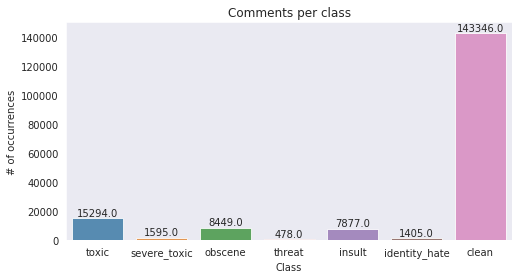

In [28]:
# Plot comments per class
plt.figure(figsize=(8, 4))
x = cmnt_count_per_cat.index    # classes
y = cmnt_count_per_cat.values   # comment count per class 
ax = sns.barplot(x, y, alpha=0.8)
ax.set(title="Comments per class", xlabel="Class", ylabel="# of occurrences")
rects = ax.patches
for rect, cmnt_count in zip(rects, y):
    x_pos = rect.get_x() + rect.get_width()/2
    y_pos = rect.get_height()
    ax.text(x_pos, y_pos, cmnt_count, ha='center', va='bottom')
plt.show()   

In [29]:
total_class_count = train.iloc[:, 2:-1].values.sum()
total_class_count

35098

There are total 159571 comments in the training set, of which 143346 are clean comments and rest (16,225) have 35098 classes assigned. That means each comment is not labelled with a single, but a multiple classes. So it's not a multi-class classification problem, it's a multi-label classification problem i.e., a comment is tagged more than one class (eg. a comment is classified as toxic and insult).      

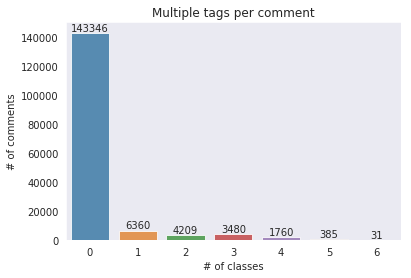

In [30]:
# How many comments have multiple tags?
classes_count_per_cmnt = train.iloc[:, 2:-1].sum(axis=1)
classes_count = classes_count_per_cmnt.value_counts().index
cmnt_count = classes_count_per_cmnt.value_counts().values

plt.figure(figsize=(6, 4))
ax = sns.barplot(classes_count, cmnt_count, alpha=0.8)
ax.set(title='Multiple tags per comment', xlabel='# of classes', ylabel='# of comments')
rects = ax.patches
for rect, cls_count in zip(rects, cmnt_count):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), cls_count, ha='center', va='bottom')
plt.show()    

From above graph it is clear that most of the comments are with single tag when compared with others

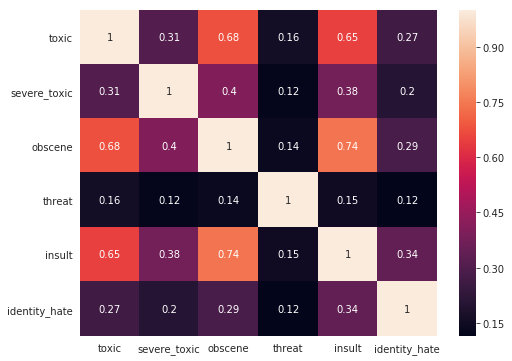

In [31]:
# Is there any correlation between depedent varaibles (i.e., labels)?
tmp_df = train.iloc[:, 2:-1]

correlation = tmp_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, annot=True)

The above plot indicates a pattern of co-occurence but Pandas default `Corr` function which uses Pearson correlation does not apply here, since the varaibles involved are Categorical (binary) variables.

So to find the pattern between two categorical variables we can use like,
1. confusion matrix/crosstab
2. cramer's V statistic
    + cramer's V stat is an extension of the chi-square test where the extent/strength of the association is measured.  

In [32]:
def hightlight_min(data, color='yellow'):
    """
    highlight the minimum in a series or dataframe 
    """
    attr = f'background-color: {color}'
    if data.ndim == 1:   # Series from .apply(axis=0) or axis=1 
        is_min = data == data.min()
        return [attr if val else '' for val in is_min]
    else:   # DataFrame from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''), index=data.index, columns=data.columns)

In [33]:
# Crosstab
# Since crosstab with all the 6 classes is impossible to visualize, let's take one class (toxic) and look at it with other tags 
main_col = 'toxic'
corr_mats = [pd.crosstab(tmp_df[main_col], tmp_df[other_col]) 
             for other_col in tmp_df.columns[1:]]
out = pd.concat(corr_mats, axis=1, keys=tmp_df.columns[1:])
out = out.style.apply(hightlight_min, axis=0)
out

The above table represents the Crosstab/confusion matrix of Toxic comments with the other classes.

Some interesting observations:
+ A **severe_toxic** comment is always a **toxic**
+ Other classes seem to be a subset of **toxic** barring a few exceptions

In [34]:
# look at 1, 2 in References section
def cramers_corrected_stat(confusion_matrix):
    """
    Calculate Cramers V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr - 1), (rcorr-1)))

In [35]:
# For now we use cramer's V test on Toxic and Severe toxic for now 
col1 = 'toxic'
col2 = 'severe_toxic'
confusion_matrix = pd.crosstab(tmp_df[col1], tmp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
print(f"The correlation between toxic and severe toxic using Cramer's stat = {cramers_corrected_stat(confusion_matrix)}")

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between toxic and severe toxic using Cramer's stat = 0.30850290540548614


In [36]:
# simlarly finding the correlation between all the dependent variables with all other dependent variables
ind_cols = np.array(tmp_df.columns)
for i in range(len(ind_cols)-1):
    col1 = ind_cols[i]
    for col2 in ind_cols[i+1:]:
        print(f"The correlation between {col1} and {col2} = {cramers_corrected_stat(pd.crosstab(tmp_df[col1], tmp_df[col2])):.2}")

The correlation between toxic and severe_toxic = 0.31
The correlation between toxic and obscene = 0.68
The correlation between toxic and threat = 0.16
The correlation between toxic and insult = 0.65
The correlation between toxic and identity_hate = 0.27
The correlation between severe_toxic and obscene = 0.4
The correlation between severe_toxic and threat = 0.12
The correlation between severe_toxic and insult = 0.38
The correlation between severe_toxic and identity_hate = 0.2
The correlation between obscene and threat = 0.14
The correlation between obscene and insult = 0.74
The correlation between obscene and identity_hate = 0.29
The correlation between threat and insult = 0.15
The correlation between threat and identity_hate = 0.11
The correlation between insult and identity_hate = 0.34


From above some dependent variables have high correlation

If you observe the data, 
1. some of the comments are extremely and mere copy paste of same thing. 
2. some comments contain IP address, user names, and some numbers(such as article ID's)

<h4 style='color: red'>Point 2 can cause huge overfitting of data</h4>

## Wordclouds - Frequent words
Now, we will look at the words that are associated with these classes

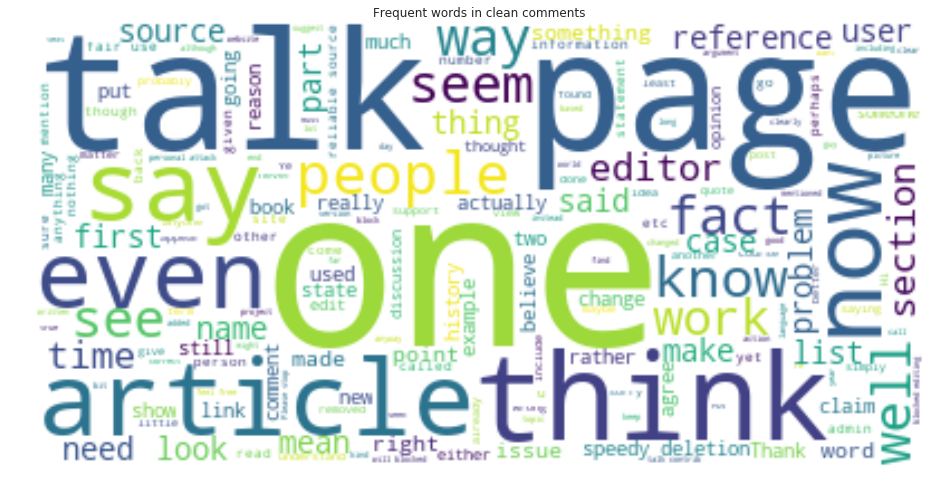

In [37]:
# wordcloud for clean text, i.e., comments with only one label
clean_cmnt_subset = train[train.clean == True] 
clean_cmnts = clean_cmnt_subset.comment_text.values
wc = WordCloud(max_font_size=100, max_words=2000, background_color='white')
wc.generate(" ".join(clean_cmnts))
plt.figure(figsize=(16, 14))
plt.axis("off")
plt.title("Frequent words in clean comments")
plt.imshow(wc, interpolation='bilinear')
plt.show()

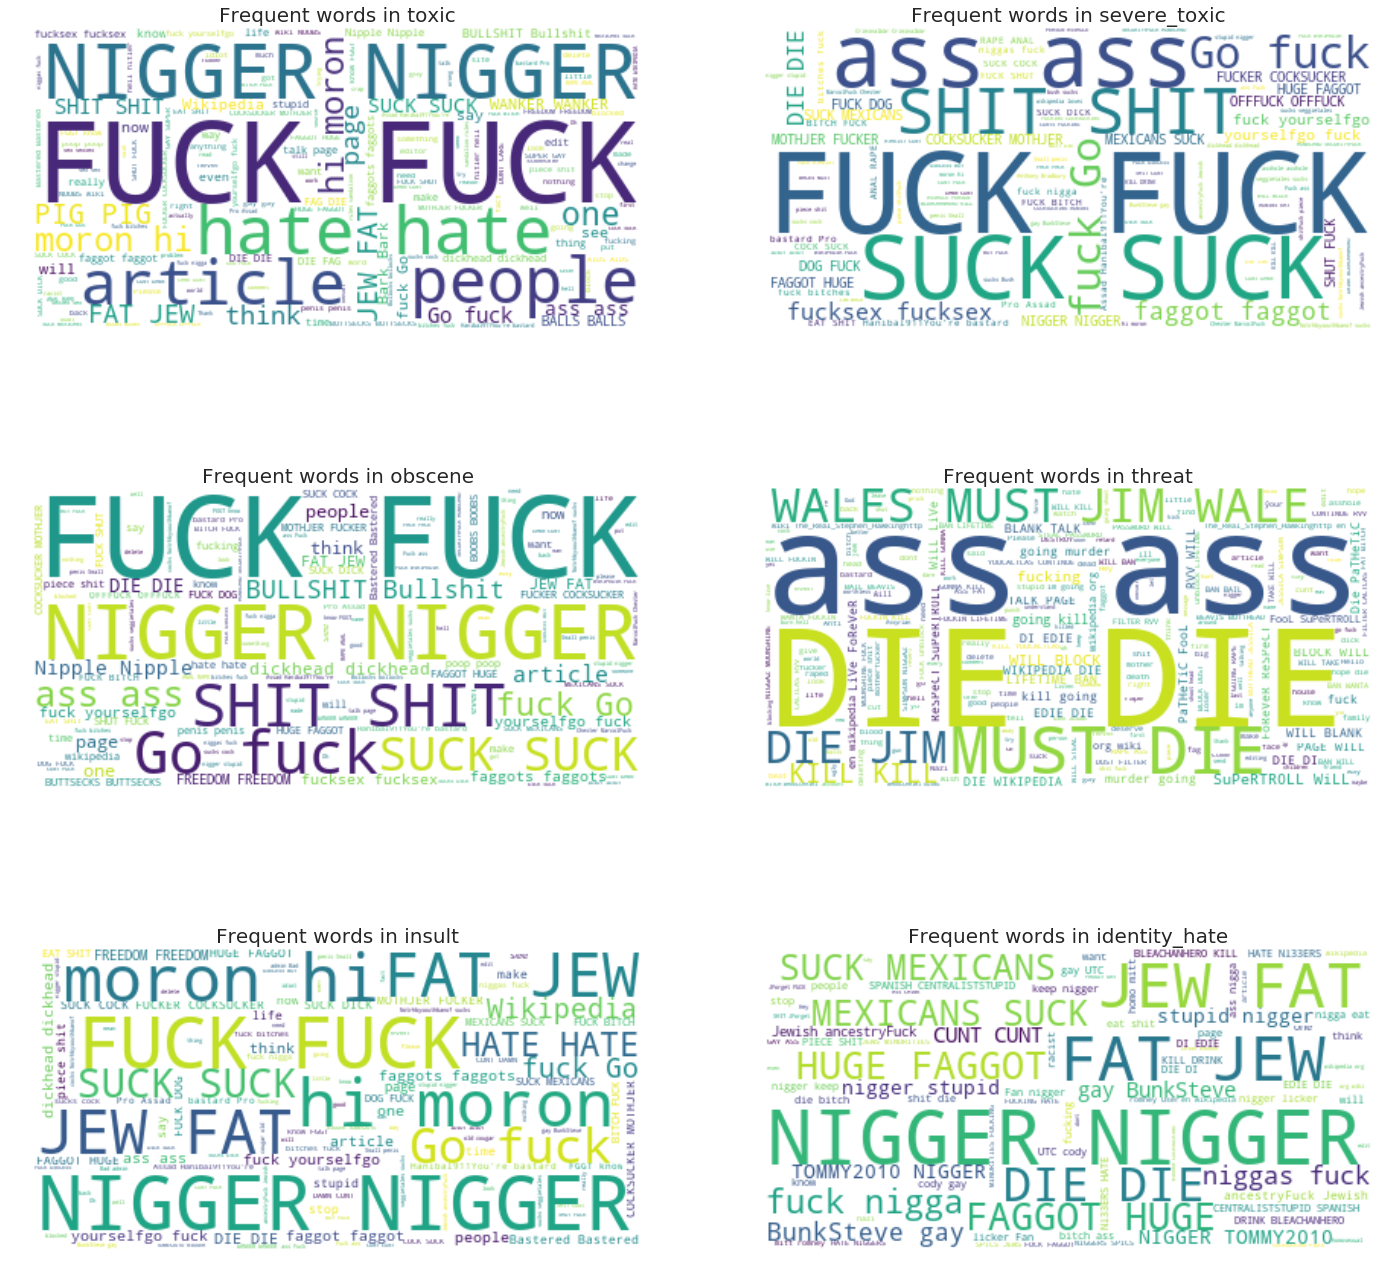

In [38]:
# Similarly word clouds for all classes are
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24, 24))
classes = train.columns[2:-1].values
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        cls = classes[(i*2)+j]
        cmnt_subset = train[train[cls] == True]
        wc = WordCloud(max_font_size=100, max_words=2000, background_color="white")
        wc.generate(" ".join(cmnt_subset.comment_text.values))
        col.set_title(f"Frequent words in {cls}", fontdict={'fontsize': 20})
        col.axis("off")
        col.imshow(wc, interpolation="bilinear")
plt.show()

## Feature Engineering
### Direct features
Features which are directly due to words/content. We would be exploring the following techniques 
+ Word frequency features
    + Count features
    + Bigrams
    + Trigrams
+ Vector distance mapping of words (Eg: Word2Vec)
+ Sentiment score

### Indirect feature
Experimental features
+ Count of sentences 
+ Count of words
+ Count of unique words
+ Count of letters
+ Count of punctuations
+ Count of uppercase words/letters
+ Count of stopwords
+ Avg length of each word

### Leaky features
From the training sets we know that the comments also contain identifier information (eg: IP, username etc). We can create features out of then but, it will certainly lead to overfitting to this specific data use-case.
+ toxic IP scores
+ toxic users

Creating **Indirect** and **Leaky** features first. There are two reasons for this.
+ Count features (Direct features) are only useful if they are created from clean corpus
+ Also the indirect features help to compensate for loss of information when clearning the dataset.

In [39]:
train.iloc[:, 0:2].head()

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


In [40]:
cmnt_corpus = pd.concat([train.iloc[:, 0:2], test.iloc[:, 0:2]])
cmnt_df = cmnt_corpus.reset_index(drop=True)

In [45]:
%%time
## Indirect features
# Count of sentences
cmnt_df['count_sents'] = cmnt_df['comment_text'].apply(lambda x: len(re.findall("\n", str(x)))+1)
# Count of words
cmnt_df['count_words'] = cmnt_df['comment_text'].apply(lambda x: len(str(x).split()))
# Count of unique words
cmnt_df['count_unique_words'] = cmnt_df['comment_text'].apply(lambda x: len(set(str(x).split()))) 
# Count of letters
cmnt_df['count_letters'] = cmnt_df['comment_text'].apply(lambda x: len(str(x)))
# Count of punctuations
cmnt_df['count_punctuations'] = cmnt_df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# Count of Upper-case words
cmnt_df['count_upper_words'] = cmnt_df['comment_text'].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))
# Count of title words
cmnt_df['count_title_words'] = cmnt_df['comment_text'].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))
# Count of stopwords
cmnt_df['count_stopwords'] = cmnt_df['comment_text'].apply(lambda x: len([word for word in str(x).split() if word.lower() in eng_stopwords]))
# Avg length of each word 
cmnt_df['avg_word_length'] = cmnt_df['comment_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

/home/suneel/miniconda3/envs/nlp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


CPU times: user 28.6 s, sys: 188 ms, total: 28.8 s
Wall time: 22.2 s


In [48]:
tmp = cmnt_df['comment_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

In [50]:
tmp[tmp.isnull()]

214713   NaN
Name: comment_text, dtype: float64

In [52]:
cmnt_df.iloc[214713]

id                    5bbabc3b14cc1f7f
comment_text                          
count_sents                          1
count_words                          0
count_unique_words                   0
count_letters                        1
count_punctuations                   0
count_upper_words                    0
count_title_words                    0
count_stopwords                      0
avg_word_length                    NaN
Name: 214713, dtype: object

In [54]:
test[test['id'] == '5bbabc3b14cc1f7f']

,id,comment_text
55142,5bbabc3b14cc1f7f,


In test set there is one missing comment

In [56]:
cmnt_df.head()

,id,comment_text,count_sents,count_words,count_unique_words,count_letters,count_punctuations,count_upper_words,count_title_words,count_stopwords,avg_word_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769


In [58]:
## Derived features
# percentage of unique Words in each comment
cmnt_df['unique_word_percentage'] = cmnt_df['count_unique_words']*100 / cmnt_df['count_words']
# percentage of punctuations in each comment
cmnt_df['punct_percentage'] = cmnt_df['count_punctuations']*100 / cmnt_df['count_words']

In [1]:
# Separate train and test set features
train_features = cmnt_df.iloc[:len(train),]
test_features = cmnt_df.iloc[len(train):,]
# join classes to the newly created feature sets
train_features = pd.concat([train_features, train.iloc[:, 2:]], axis=1)

NameError: name 'cmnt_df' is not defined

### References
1. https://www.spss-tutorials.com/chi-square-independence-test/#what-is-it
2. https://www.spss-tutorials.com/cramers-v-what-and-why/